# Layout Aware Monte Carlo with GDSFactory
> Towards layout-aware optimization and monte-carlo simulations

In [1]:
import os

os.environ["LOGURU_LEVEL"] = "CRITICAL"
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
import itertools
import sys
from functools import partial
from typing import List

import gdsfactory as gf  # conda install gdsfactory
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meep  # conda install pymeep=\*=mpi_mpich_\*
import numpy as np
import sax
from gdsfactory.quickplotter import quickplot
from gplugins.modes import find_modes_waveguide
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from tqdm.notebook import tqdm, trange

Using MPI version 4.0, 1 processes


In [3]:

# In interactive notebooks it's often pretty annoying to have a cache...
# let's disable gdsfactory cache with this horrible one-liner 🙂
sys.modules["gdsfactory.cell"].CACHE = type(
    "FakeCache", (dict,), {"__setitem__": (lambda *args: None)}
)()

## Simple MZI Layout

In [4]:
@gf.cell
def simple_mzi():
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=10.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in
    mmi_out_ = c << mmi_out
    straight_top1_ = c << half_delay_straight
    straight_top2_ = c << half_delay_straight
    bend_top1_ = c << bend
    bend_top2_ = (c << bend).mirror()
    bend_top3_ = (c << bend).mirror()
    bend_top4_ = c << bend
    bend_btm1_ = (c << bend).mirror()
    bend_btm2_ = c << bend
    bend_btm3_ = c << bend
    bend_btm4_ = (c << bend).mirror()

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    bend_top3_.connect("o1", bend_top2_.ports["o2"])
    straight_top2_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top2_.ports["o2"])

    bend_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])

    mmi_out_.connect("o1", bend_btm4_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c

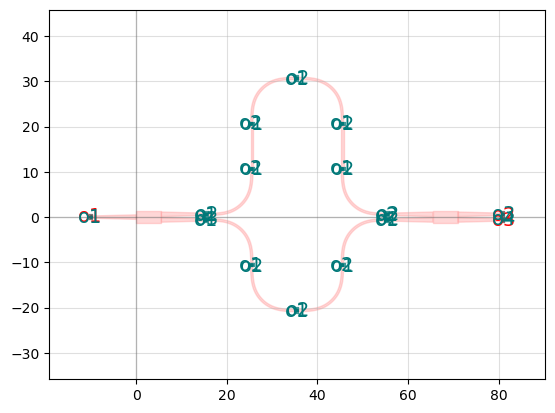

In [5]:
mzi = simple_mzi()
quickplot(mzi);

## Simulate MZI

We used the following components to construct the MZI circuit:

- mmi1x2
- mmi2x2
- straight
- bend_euler

We need a model for each of those components to be able to simulate the circuit with SAX. Let's create some dummy models for now.

In [6]:
def mmi1x2():
    S = {
        ("o1", "o2"): 0.5**0.5,
        ("o1", "o3"): 0.5**0.5,
    }
    return sax.reciprocal(S)

In [7]:
def mmi2x2():
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)

In [8]:
def straight(length=10.0, width=0.5):
    S = {("o1", "o2"): 1.0}  # we'll improve this model later!
    return sax.reciprocal(S)

In [9]:
def bend_euler(length=10.0, width=0.5, dy=10.0, radius_min=7, radius=10):
    return straight(length=length, width=width)  # stub with straight for now

Let's create a SAX circuit with our very simple placeholder models:

In [10]:
models = {
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
    "bend_euler": bend_euler,
}
mzi1, _ = sax.circuit(mzi.get_netlist_recursive(), models=models)
?mzi1

the resulting circuit is just a model function on its own! Hence, calling it will give the result:

In [11]:
mzi1()

{('o1', 'o1'): Array(0.+0.j, dtype=complex128),
 ('o1', 'o2'): Array(0.5+0.5j, dtype=complex128),
 ('o1', 'o3'): Array(0.5+0.5j, dtype=complex128),
 ('o2', 'o1'): Array(0.5+0.5j, dtype=complex128),
 ('o2', 'o2'): Array(0.+0.j, dtype=complex128),
 ('o2', 'o3'): Array(0.+0.j, dtype=complex128),
 ('o3', 'o1'): Array(0.5+0.5j, dtype=complex128),
 ('o3', 'o2'): Array(0.+0.j, dtype=complex128),
 ('o3', 'o3'): Array(0.+0.j, dtype=complex128)}

## Waveguide Model

Our waveguide model is not very good (it just has 100% transmission and no phase). Let's do something about the phase calculation. To do this, we need to find the effective index of the waveguide in relation to its parameters. We can use meep to obtain the waveguide parameters. Let's use gdsfactory's convenient `find_modes_waveguide` function to find the waveguide modes. This function uses `mpb` under the hood.

In [12]:
def silicon_index(wl):
    """a rudimentary silicon refractive index model"""
    a, b = 0.2411478522088102, 3.3229394315868976
    return a / wl + b

In [13]:
wavelengths = np.linspace(1.5, 1.6, 10)
widths = np.linspace(0.4, 0.6, 5)

wavelengths, widths = np.mgrid[1.5:1.6:10j, 0.4:0.6:5j]
neffs = np.zeros_like(wavelengths)
neffs_ = neffs.ravel()

for i, (wl, w) in enumerate(zip(tqdm(wavelengths.ravel()), widths.ravel())):
    modes = find_modes_waveguide(
        wavelength=wl,
        core_width=w,
        mode_number=1,
        core_thickness=0.22,
        slab_thickness=0.0,
        core_material=silicon_index(wl),
        clad_material=1.4,
    )
    neffs_[i] = np.real(modes[1].neff)

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
def visualize_mode(mode, field):
    field, comp = list(field)
    idx = ["x", "y", "z"].index(comp)
    x, y = getattr(mode, "y"), getattr(mode, "z")
    Y, X = np.meshgrid(y, x)
    mode = np.abs(getattr(mode, field)[..., 0, idx]) ** 2
    plt.contour(
        X, Y, mode, cmap="inferno", levels=np.linspace(mode.min(), mode.max(), 8)
    )
    plt.colorbar(label="mode")
    plt.grid(True, alpha=0.4)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.xlabel("y")
    plt.ylabel("z")
    plt.axis("scaled")
    plt.grid(True)
    plt.show()

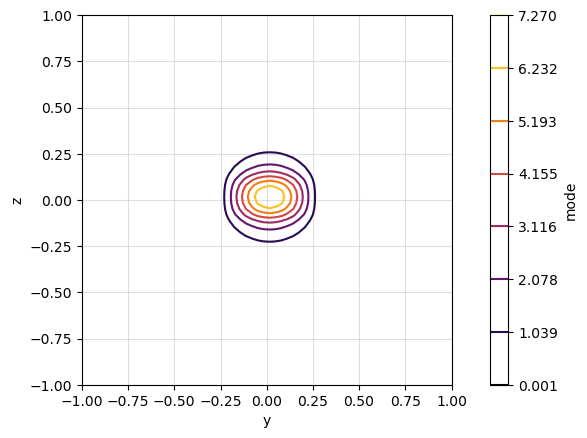

In [15]:
visualize_mode(modes[1], "Hz")

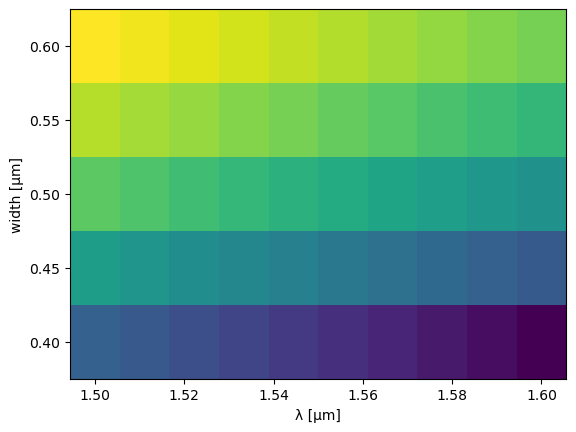

In [16]:
plt.pcolormesh(wavelengths, widths, neffs)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.show()

In [17]:
_grid = [jnp.sort(jnp.unique(wavelengths)), jnp.sort(jnp.unique(widths))]
_data = jnp.asarray(neffs)


@jax.jit
def _get_coordinate(arr1d: jnp.ndarray, value: jnp.ndarray):
    return jnp.interp(value, arr1d, jnp.arange(arr1d.shape[0]))


@jax.jit
def _get_coordinates(arrs1d: List[jnp.ndarray], values: jnp.ndarray):
    # don't use vmap as arrays in arrs1d could have different shapes...
    return jnp.array([_get_coordinate(a, v) for a, v in zip(arrs1d, values)])


@jax.jit
def neff(wl=1.55, width=0.5):
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(wl), jnp.asarray(width)), 0)
    coords = _get_coordinates(_grid, params)
    return jax.scipy.ndimage.map_coordinates(_data, coords, 1, mode="nearest")


neff(wl=[1.52, 1.58], width=[0.5, 0.55])

Array([2.47592927, 2.48040468], dtype=float64)

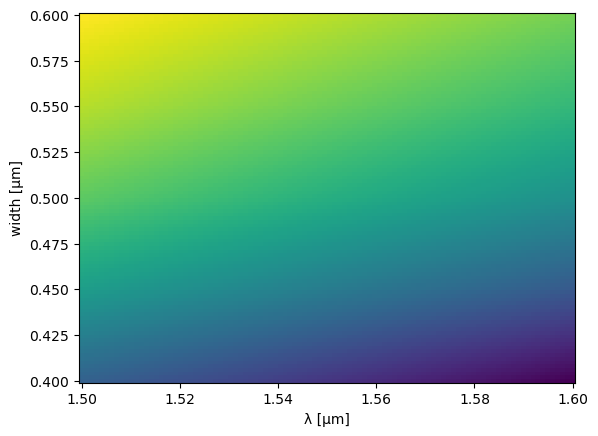

In [18]:
wavelengths_ = np.linspace(wavelengths.min(), wavelengths.max(), 100)
widths_ = np.linspace(widths.min(), widths.max(), 100)
wavelengths_, widths_ = np.meshgrid(wavelengths_, widths_)
neffs_ = neff(wavelengths_, widths_)
plt.pcolormesh(wavelengths_, widths_, neffs_)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.show()

In [19]:
def straight(wl=1.55, length=10.0, width=0.5):
    S = {
        ("o1", "o2"): jnp.exp(2j * np.pi * neff(wl=wl, width=width) / wl * length),
    }
    return sax.reciprocal(S)

Even though this still is lossless transmission, we're at least modeling the phase correctly.

In [20]:
straight()

{('o1', 'o2'): Array(-0.01230815-0.99992425j, dtype=complex128),
 ('o2', 'o1'): Array(-0.01230815-0.99992425j, dtype=complex128)}

## Simulate MZI again

In [21]:
models["straight"] = straight
mzi2, _ = sax.circuit(mzi.get_netlist_recursive(), models=models)
mzi2()

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore


{('o1', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o1', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o1', 'o3'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o3'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o3'): Array(nan+nanj, dtype=complex128)}

/opt/conda/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-

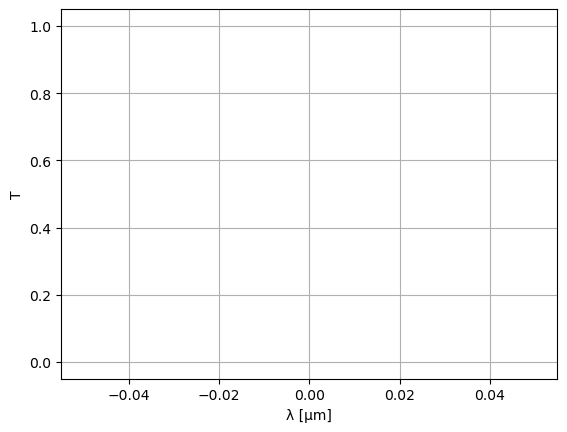

In [22]:
wl = jnp.linspace(1.51, 1.59, 1000)
S = mzi2(wl=wl)
plt.plot(wl, abs(S["o1", "o2"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [μm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

## Optimize MZI

We'd like to optimize an MZI such that one of the minima is at 1550nm. To do this, we need to define a loss function for the circuit at 1550nm. This function should take the parameters that you want to optimize as positional arguments:

In [23]:
@jax.jit
def loss_fn(delta_length):
    S = mzi2(
        wl=1.55,
        straight_1={"length": delta_length / 2},
        straight_2={"length": delta_length / 2},
    )
    return jnp.mean(jnp.abs(S["o1", "o2"]) ** 2)

We can use this loss function to define a grad function which works on the parameters of the loss function:

In [24]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, we need to define a JAX optimizer, which on its own is nothing more than three more functions:  an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

In [25]:
initial_delta_length = 10.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

Given all this, a single training step can be defined:

In [26]:
def step_fn(step, state):
    params = params_fn(state)
    loss = loss_fn(params)
    grad = grad_fn(params)
    state = update_fn(step, grad, state)
    return loss, state

And we can use this step function to start the training of the MZI:

In [27]:
for step in (
    pb := trange(300)
):  # the first two iterations take a while because the circuit is being jitted...
    loss, state = step_fn(step, state)
    pb.set_postfix(loss=f"{loss:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

In [28]:
delta_length = params_fn(state)
delta_length

Array(nan, dtype=float64)

Let's see what we've got over a range of wavelengths:

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

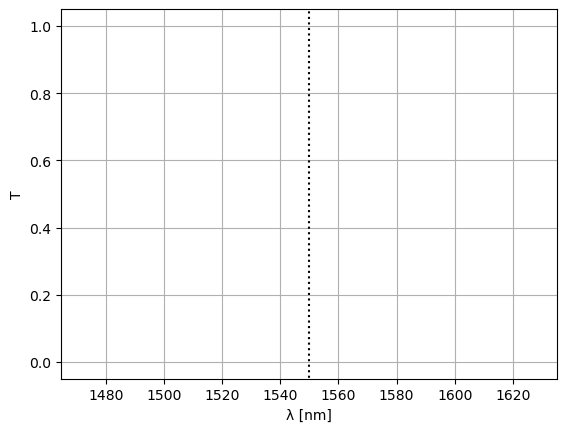

In [29]:
S = mzi2(
    wl=wl,
    straight_1={"length": delta_length / 2},
    straight_2={"length": delta_length / 2},
)
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], ls=":", color="black")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

Note that we could've just as well optimized the waveguide width:

  0%|          | 0/300 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

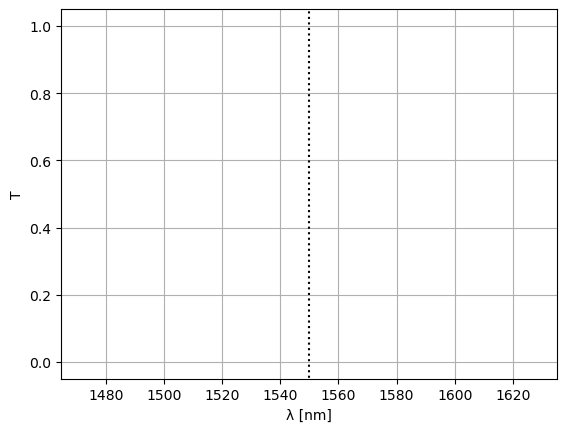

In [30]:
@jax.jit
def loss_fn(width):
    S = mzi2(
        wl=1.55,
        straight_1={"width": width},
        straight_2={"width": width},
    )
    return jnp.mean(jnp.abs(S["o1", "o2"]) ** 2)


grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)
initial_width = 0.5
init_fn, update_fn, params_fn = opt.adam(step_size=0.01)
state = init_fn(initial_width)
for step in (
    pb := trange(300)
):  # the first two iterations take a while because the circuit is being jitted...
    loss, state = step_fn(step, state)
    pb.set_postfix(loss=f"{loss:.6f}")

optim_width = params_fn(state)
S = Sw = mzi2(
    wl=wl,
    straight_1={"width": optim_width},
    straight_2={"width": optim_width},
)
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

## Layout-aware Monte Carlo

Let's assume the waveguide width changes with a certain correlation length. We can create a 'wafermap' of width variations by randomly varying the width and low pass filtering with a spatial frequency being the inverse of the correlation length (there are probably better ways to do this, but this works for this tutorial).

In [31]:
def create_wafermaps(
    placements, correlation_length=1.0, num_maps=1, mean=0.0, std=1.0, seed=None
):
    dx = dy = correlation_length / 200
    xs = [p["x"] for p in placements.values()]
    ys = [p["y"] for p in placements.values()]
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    wx, wy = xmax - xmin, ymax - ymin
    xmin, xmax, ymin, ymax = xmin - wx, xmax + wx, ymin - wy, ymax + wy
    x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    if seed is None:
        r = np.random
    else:
        r = np.random.RandomState(seed=seed)
    W0 = r.randn(num_maps, x.shape[0], y.shape[0])

    fx = fftshift(fftfreq(x.shape[0], d=x[1] - x[0]))
    fy = fftshift(fftfreq(y.shape[0], d=y[1] - y[0]))
    fY, fX = np.meshgrid(fy, fx)

    fW = fftshift(fft2(W0))

    if correlation_length >= min(x.shape[0], y.shape[0]):
        fW = np.zeros_like(fW)
    else:
        fW = np.where(np.sqrt(fX**2 + fY**2)[None] > 1 / correlation_length, 0, fW)

    W = np.abs(fftshift(ifft2(fW))) ** 2

    mean_ = W.mean(1, keepdims=True).mean(2, keepdims=True)

    std_ = W.std(1, keepdims=True).std(2, keepdims=True)
    if (std_ == 0).all():
        std_ = 1

    W = (W - mean_) / std_

    W = W * std + mean

    return x, y, W

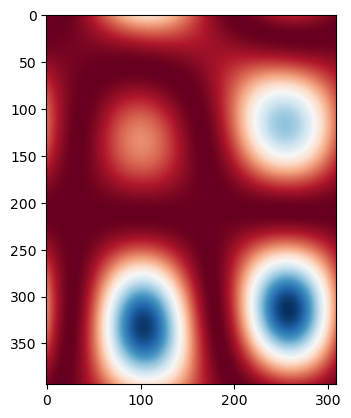

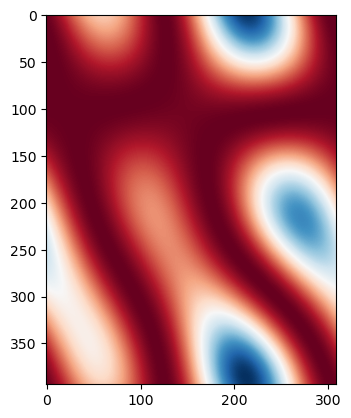

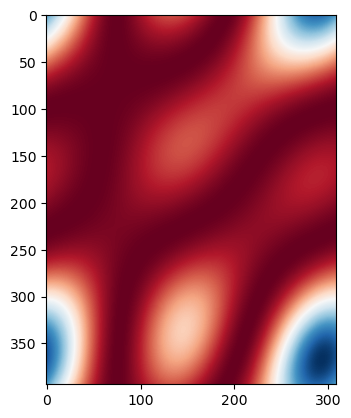

In [32]:
placements = mzi.get_netlist()["placements"]
xm, ym, wmaps = create_wafermaps(
    placements,
    correlation_length=100,
    mean=0.5,
    std=0.002,
    num_maps=100,
    seed=42,
)

for i, wmap in enumerate(wmaps):
    plt.imshow(wmap, cmap="RdBu")
    plt.show()
    if i == 2:
        break

In [33]:
def widths(xw, yw, wmaps, x, y):
    _wmap_grid = [xw, yw]
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(x), jnp.asarray(y)), 0)
    coords = _get_coordinates(_wmap_grid, params)

    map_coordinates = partial(
        jax.scipy.ndimage.map_coordinates, coordinates=coords, order=1, mode="nearest"
    )
    w = jax.vmap(map_coordinates)(wmaps)
    return w

Let's now sample the MZI width variation on the wafer map (let's assume a single width variation per point):

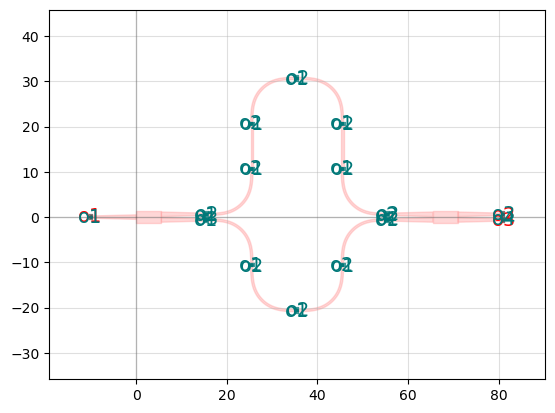

In [34]:
quickplot(mzi);

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

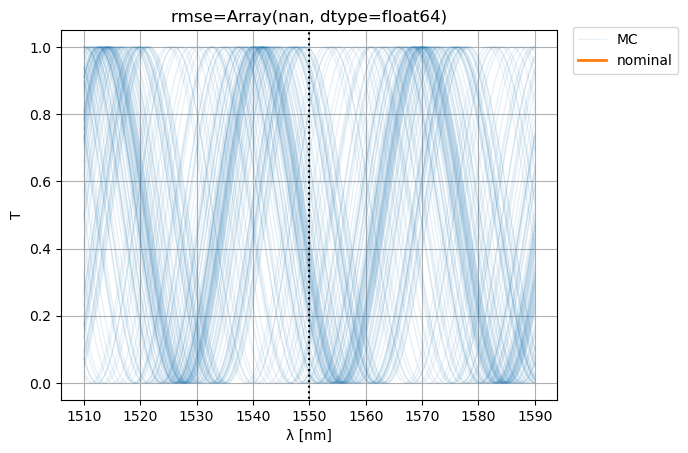

In [35]:
mzi_params = sax.get_settings(mzi2)
placements = mzi.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi2(wl=wl)
S = mzi2(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

## Compact MZI

Let's see if we can improve variability (i.e. the RMSE w.r.t. nominal) by making the MZI more compact:

In [36]:
@gf.cell
def compact_mzi():
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight()
    middle_straight = gf.components.straight(length=6.0)
    half_middle_straight = gf.components.straight(3.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in

    bend_top1_ = c << bend
    straight_top1_ = c << half_delay_straight
    bend_top2_ = (c << bend).mirror()
    straight_top2_ = c << middle_straight
    bend_top3_ = (c << bend).mirror()
    straight_top3_ = c << half_delay_straight
    bend_top4_ = c << bend

    straight_btm1_ = c << half_middle_straight
    bend_btm1_ = c << bend
    bend_btm2_ = (c << bend).mirror()
    bend_btm3_ = (c << bend).mirror()
    bend_btm4_ = c << bend
    straight_btm2_ = c << half_middle_straight

    mmi_out_ = c << mmi_out

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    straight_top2_.connect("o1", bend_top2_.ports["o2"])
    bend_top3_.connect("o1", straight_top2_.ports["o2"])
    straight_top3_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top3_.ports["o2"])

    straight_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm1_.connect("o1", straight_btm1_.ports["o2"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])
    straight_btm2_.connect("o1", bend_btm4_.ports["o2"])

    mmi_out_.connect("o1", straight_btm2_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c

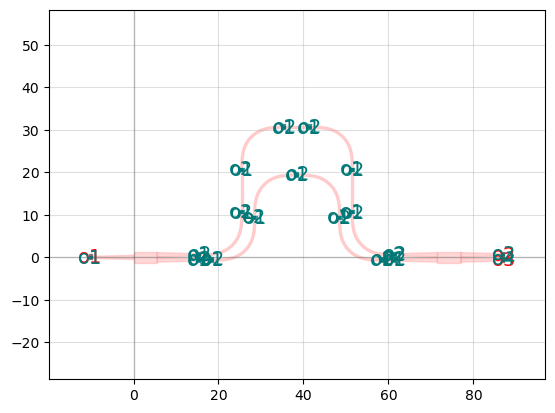

{('o1', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o1', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o1', 'o3'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o2', 'o3'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o1'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o2'): Array(nan+nanj, dtype=complex128),
 ('o3', 'o3'): Array(nan+nanj, dtype=complex128)}

In [37]:
compact_mzi1 = compact_mzi()
quickplot(compact_mzi1)
placements = compact_mzi1.get_netlist()["placements"]
mzi3, _ = sax.circuit(compact_mzi1.get_netlist_recursive(), models=models)
mzi3()

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=False, order=order)  # type: ignore
/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2206: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will resu

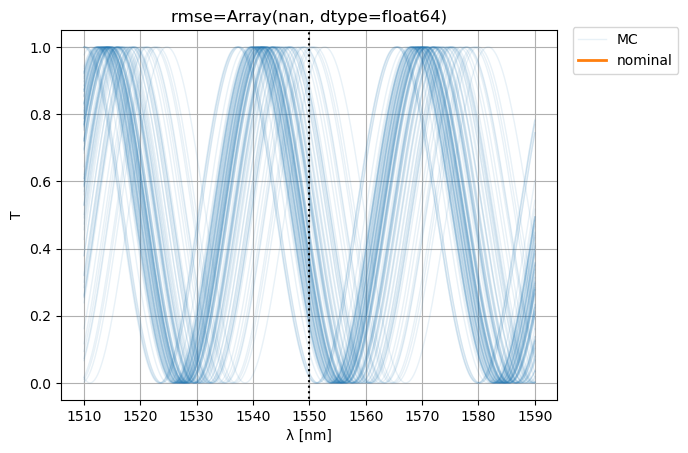

In [38]:
mzi_params = sax.get_settings(mzi3)
placements = compact_mzi1.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi3(wl=wl)
S = mzi3(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()